In [168]:
%pip install scikit-learn 
%pip install pandas
%pip install yfinance
%pip install plotly
%pip install openpyxl
%pip install matplotlib
%pip install tensorflow
%pip install keras

import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf
import pandas as pd
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [199]:
btc_price_history = yf.download('BTC-USD', period='max')

btc_price_history.to_csv('btc_price_history.csv')

[*********************100%***********************]  1 of 1 completed


In [200]:
btc_df = pd.read_csv('./btc_price_history.csv')
btc_df.columns = btc_df.columns.str.lower()
btc_df['date'] = pd.to_datetime(btc_df['date'])
btc_df.rename(columns={'close': 'btc_close'}, inplace=True)
btc_df = btc_df.drop(['adj close', 'date', 'open', 'high', 'low'], axis=1)

In [201]:
btc_df

,btc_close,volume
0,457.334015,21056800
1,424.440002,34483200
2,394.795990,37919700
3,408.903992,36863600
4,398.821014,26580100
...,...,...
3169,26851.277344,11056770492
3170,27225.726562,13697203143
3171,26334.818359,16299104428
3172,26476.207031,13851122697


In [202]:
# Split into train and test
train_split = int(len(btc_df) * 0.90)
test_split = len(btc_df) - train_split
df_train = btc_df.iloc[0:train_split, :]
df_test = btc_df.iloc[train_split:len(btc_df), :]

In [203]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_train.index, y=df_train['btc_close'], name="BTC Close"), secondary_y=False)
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['volume'], name="Volume", line=dict(color='purple')), secondary_y=True)

fig.update_layout(title_text="Bitcoin Close Prices and Volume")
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="BTC Close Price (Log Scale)", secondary_y=False, type="log", dtick=1)
fig.update_yaxes(title_text="Volume (Log Scale)", secondary_y=True, type="log", dtick=1)
fig.show()

In [204]:
# Turn into np array
train_data = df_train.loc[:, ["btc_close", "volume"]].values
test_data = df_test.loc[:, ["btc_close", "volume"]].values
# float32 if need to save memory.
train_data = train_data.astype("float32")
test_data = test_data.astype("float32")
print(train_data.shape,test_data.shape)

(2856, 2) (318, 2)


In [205]:
scalers = {col: MinMaxScaler(feature_range=(0, 1)) for col in ["btc_close", "volume"]}

for col in ["btc_close", "volume"]:
    train_data[:, df_train.columns.get_loc(col)] = scalers[col].fit_transform(train_data[:, df_train.columns.get_loc(col)].reshape(-1, 1)).ravel()
    test_data[:, df_test.columns.get_loc(col)] = scalers[col].transform(test_data[:, df_test.columns.get_loc(col)].reshape(-1, 1)).ravel()

In [206]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Scaled BTC Close Price", "Scaled Volume"))

fig.add_trace(go.Scatter(x=df_train.index, y=train_data[:, df_train.columns.get_loc("btc_close")], name='btc_close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_train.index, y=train_data[:, df_train.columns.get_loc("volume")], name='volume', line=dict(color='orange')), row=1, col=2)
fig.update_layout(height=500, width=1000, showlegend=True)
fig.show()

In [207]:
# split train data, so it now becomes the train & validation parts. The original untouched 'df_test' split from 'btc_df' will become the test part later.
train_split = int(len(train_data) * 0.50)
val_split = len(train_data) - train_split
train_scaled = train_data[0:train_split, :]
val_scaled = train_data[train_split:len(train_data), :]

print(train_scaled.shape, val_scaled.shape)

(1428, 2) (1428, 2)


In [208]:
def create_sequences(data, time_step):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        slice = data[i:(i + time_step), :]
        dataX.append(slice)
        dataY.append(data[i + time_step, 0]) # '0' because 'btc_close' is in the first column, which is what we are predicting.
    return np.array(dataX), np.array(dataY)

time_step = 10
trainX, trainY = create_sequences(train_scaled, time_step)
valX, valY = create_sequences(val_scaled, time_step)
testX, testY = create_sequences(test_data, time_step)

print(trainX.shape, trainY.shape, valX.shape, valY.shape, testX.shape, testY.shape)

(1417, 10, 2) (1417,) (1417, 10, 2) (1417,) (307, 10, 2) (307,)


In [209]:
# Build Model
model = Sequential()
model.add(LSTM(256, input_shape = (time_step, 2)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss= "mean_squared_error", optimizer = "adam")
model.fit(trainX, trainY, epochs=50, batch_size=50)

Epoch 1/50
29/29 [==============================] - 2s 9ms/step - loss: 6.3758e-04
Epoch 2/50
29/29 [==============================] - 0s 10ms/step - loss: 9.4913e-05
Epoch 3/50
29/29 [==============================] - 0s 9ms/step - loss: 9.0247e-05
Epoch 4/50
29/29 [==============================] - 0s 9ms/step - loss: 6.8839e-05
Epoch 5/50
29/29 [==============================] - 0s 9ms/step - loss: 6.6556e-05
Epoch 6/50
29/29 [==============================] - 0s 9ms/step - loss: 7.6349e-05
Epoch 7/50
29/29 [==============================] - 0s 9ms/step - loss: 7.8652e-05
Epoch 8/50
29/29 [==============================] - 0s 9ms/step - loss: 7.7164e-05
Epoch 9/50
29/29 [==============================] - 0s 10ms/step - loss: 1.2591e-04
Epoch 10/50
29/29 [==============================] - 0s 11ms/step - loss: 6.5091e-05
Epoch 11/50
29/29 [==============================] - 0s 9ms/step - loss: 6.0774e-05
Epoch 12/50
29/29 [==============================] - 0s 9ms/step - loss: 5.3625e-0

In [210]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 256)               265216    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


In [211]:
# predict with model
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scalers['btc_close'].inverse_transform(trainPredict)
trainY = scalers['btc_close'].inverse_transform(trainY.reshape(-1, 1))
valPredict = scalers['btc_close'].inverse_transform(valPredict)
valY = scalers['btc_close'].inverse_transform(valY.reshape(-1, 1))
testPredict = scalers['btc_close'].inverse_transform(testPredict)
testY = scalers['btc_close'].inverse_transform(testY.reshape(-1, 1))

# calculate RMSE, pearson correlation, RMSPE, Directional Accuracy
train_score = np.sqrt(mean_squared_error(trainY, trainPredict))
val_score = np.sqrt(mean_squared_error(valY, valPredict))
test_score = np.sqrt(mean_squared_error(testY, testPredict))

corr, _ = pearsonr(testY.flatten(), testPredict[:,0])

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
# Calculate actual and predicted price changes from previous day
actual_diff = np.diff(testY.flatten())
predicted_diff = np.diff(testPredict.flatten())

# Calculate if predicted and actual changes have the same sign (indicating correct direction)
directional_accuracy = np.sum(np.sign(actual_diff) == np.sign(predicted_diff)) / len(actual_diff)

print(f"Train RMSE Score: {train_score:.2f}")
print(f"Val RMSE Score: {val_score:.2f}")
print(f"Test RMSE Score: {test_score:.2f}")
print(f"Test Pearsons correlation: {corr * 100:.2f}%")
print(f"Test RMSPE Score: {rmspe(testPredict, testY):.2f}%")
print(f"Test Directional accuracy: {directional_accuracy * 100:.2f}%")

10/10 [==============================] - 0s 3ms/step
Train RMSE Score: 332.92
Val RMSE Score: 1733.22
Test RMSE Score: 830.72
Test Pearsons correlation: 98.31%
Test RMSPE Score: 3.76%
Test Directional accuracy: 46.73%


In [212]:
trainPredictPlot = np.empty_like(train_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(trainPredict) + time_step, :] = trainPredict

valPredictPlot_new = np.empty((len(train_data), 1))
valPredictPlot_new[:, :] = np.nan
valPredictPlot_new[train_split + time_step:len(train_data)-1, :] = valPredict

testPredictPlot = np.empty_like(test_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[time_step:len(testPredict) + time_step, :] = testPredict

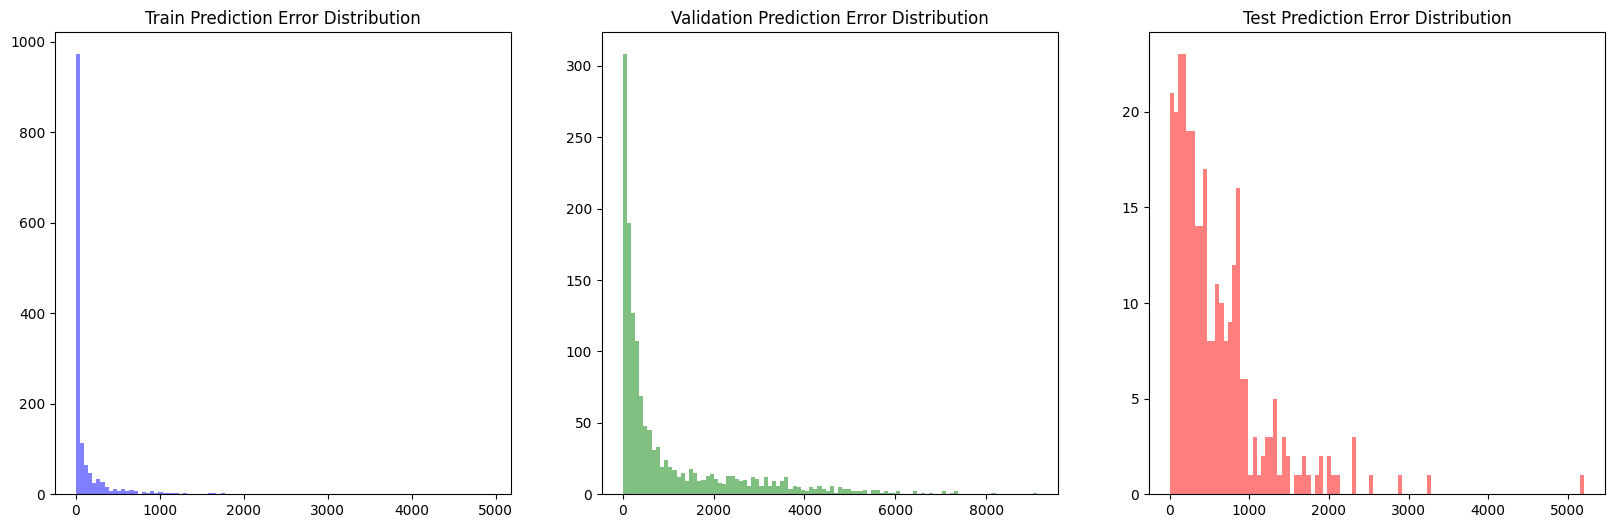

In [213]:
# Get differences between predictions and actual values
train_diff = np.abs(trainY - trainPredict)
val_diff = np.abs(valY - valPredict)
test_diff = np.abs(testY - testPredict)

# Plot histograms of the differences
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.hist(train_diff, bins=100, color='blue', alpha=0.5)
plt.title('Train Prediction Error Distribution')

plt.subplot(1, 3, 2)
plt.hist(val_diff, bins=100, color='green', alpha=0.5)
plt.title('Validation Prediction Error Distribution')

plt.subplot(1, 3, 3)
plt.hist(test_diff, bins=100, color='red', alpha=0.5)
plt.title('Test Prediction Error Distribution')

plt.show()

In [214]:
real_train_all = go.Scatter(x=np.arange(len(train_data)), y=scalers['btc_close'].inverse_transform(train_data[:,0:1]).flatten(), mode='lines', name='Real', line=dict(color='red'))
pred_train = go.Scatter(x=np.arange(len(trainPredictPlot)), y=trainPredictPlot[:,0].flatten(), mode='lines', name='Pred', line=dict(color='blue'))

real_test = go.Scatter(x=np.arange(len(train_data), len(train_data) + len(test_data)), y=scalers['btc_close'].inverse_transform(test_data[:,0:1]).flatten(), mode='lines', name='Real', line=dict(color='red'))
pred_test = go.Scatter(x=np.arange(len(train_data), len(train_data) + len(test_data)), y=testPredictPlot[:,0].flatten(), mode='lines', name='Pred', line=dict(color='blue'))

pred_val = go.Scatter(x=np.arange(len(valPredictPlot_new)), y=valPredictPlot_new[:,0].flatten(), mode='lines', name='Pred', line=dict(color='blue'))

layout1 = go.Layout(title='Training Price Prediction', xaxis=dict(title='Time'), yaxis=dict(title='Bitcoin Price'), legend=dict(x=0, y=1))
layout2 = go.Layout(title='Validation Price Prediction', xaxis=dict(title='Time'), yaxis=dict(title='Bitcoin Price'), legend=dict(x=0, y=1))
layout3 = go.Layout(title='Test Price Prediction', xaxis=dict(title='Time'), yaxis=dict(title='Bitcoin Price'), legend=dict(x=0, y=1))

fig1 = go.Figure(data=[real_train_all, pred_train], layout=layout1)
fig2 = go.Figure(data=[real_train_all, pred_val], layout=layout2)
fig3 = go.Figure(data=[real_test, pred_test], layout=layout3)

fig1.show()
fig2.show()
fig3.show()

In [185]:
# Calculate actual and predicted price changes from previous day
actual_diff = np.diff(testY.flatten())
predicted_diff = np.diff(testPredict.flatten())

# Calculate if predicted and actual changes have the same sign (indicating correct direction)
directional_accuracy = np.sum(np.sign(actual_diff) == np.sign(predicted_diff)) / len(actual_diff)

print("Directional accuracy: %.2f%%" % (directional_accuracy * 100))

Directional accuracy: 48.04%


In [ ]:
# Tools/Resources used:

# ChatGPT-3.5 & ChatGPT-4
# https://www.blockchain.com/explorer/charts (no sentiment)
# https://www.lookintobitcoin.com/ (no sentiment)
# https://studio.glassnode.com/home/charts (no sentiment)
# https://data.bitcoinity.org/markets/volume/30d?c=e&t=b (Exchanges data and some basics)
# https://charts.woobull.com/ (interesting indicators)
# https://bitinfocharts.com/comparison/bitcoin-tweets.html (has tweets and google trends but can't download)
# https://charts.coinmetrics.io/ (price only?)
# https://blockchair.com/bitcoin/charts (no sentiment)
# https://fred.stlouisfed.org/
# https://aa.usno.navy.mil/data/MoonPhases
# https://www.epochconverter.com/batch
# https://github.com/cjhutto/vaderSentiment (pip install vaderSentiment)
# https://arxiv.org/ftp/arxiv/papers/2303/2303.09397.pdf (Sentiment project with twitter)